In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def load_data(csv_file):
    if not os.path.exists(csv_file):
        csv_file = os.path.join('/mnt/data', csv_file)
    try:
        df = pd.read_csv(csv_file, encoding_errors='ignore')
    except:
        df = pd.read_csv(csv_file, sep=';', encoding_errors='ignore')
    if df.shape[1] == 1 and ';' in df.columns[0]:
        df = pd.read_csv(csv_file, sep=';', encoding_errors='ignore')
    df.columns = df.columns.str.strip()
    return df

In [2]:
csv_paths = sorted(glob('*-nba-player-stats.csv'))

season_frames = []
for path in csv_paths:
    season_label = os.path.basename(path).replace('-nba-player-stats.csv','')
    df_season = load_data(path)
    df_season['Season'] = season_label
    season_frames.append(df_season)

all_seasons = pd.concat(season_frames, ignore_index=True)
print(f"Combined seasons: {all_seasons['Season'].nunique()} seasons, {all_seasons.shape[0]} rows")

Combined seasons: 2 seasons, 1491 rows


In [3]:
pts_cols = [c for c in all_seasons.columns if 'PTS' in c.upper()]
assert len(pts_cols) == 1, f"Expcted one PTS column- found {pts_cols}"
all_seasons.rename(columns={pts_cols[0]:'PTS'}, inplace=True)

In [4]:
all_seasons.sort_values(['Player','Season'], inplace=True)
all_seasons['Next_PTS'] = all_seasons.groupby('Player')['PTS'].shift(-1)

In [5]:
df = all_seasons.dropna(subset=['Next_PTS']).copy()
print(f"Modeling data: {df.shape[0]} rows across {df['Season'].nunique()} seasons")
df['PPG_3yr_avg'] = (
    df
    .groupby('Player')['PTS']
    .rolling(3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)
df['Year_Num'] = df['Season'].str[:4].astype(int)
df['Years_Pro'] = df.groupby('Player')['Year_Num'].transform(lambda x: x - x.min())

Modeling data: 780 rows across 2 seasons


In [6]:
def preprocess_data(df, target_col='Next_PTS'):
    df = df.dropna(subset=[target_col])
    desired = [
      'Age','G','MP','FG%','3P%','FT%','TRB','AST','STL','BLK','TOV',
      'Pos','PPG_3yr_avg','Years_Pro'
    ]
    feats = [c for c in desired if c in df.columns]
    print("Using features-", feats)
    df_sel = df[feats + [target_col]].copy()
    for col in ['FG%','3P%','FT%']:
        if col in df_sel:
            df_sel[col].fillna(df_sel[col].median(), inplace=True)
    if 'Pos' in df_sel:
        df_sel['Pos'] = df_sel['Pos'].str.split('-').str[0]
    df_sel.rename(columns={target_col:'PTS_next'}, inplace=True)
    return df_sel

df_proc = preprocess_data(df)

Using features- ['Age', 'G', 'MP', 'FG%', '3P%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'Pos', 'PPG_3yr_avg', 'Years_Pro']


In [7]:
df_proc['PTS_last'] = df.loc[df_proc.index, 'PTS']

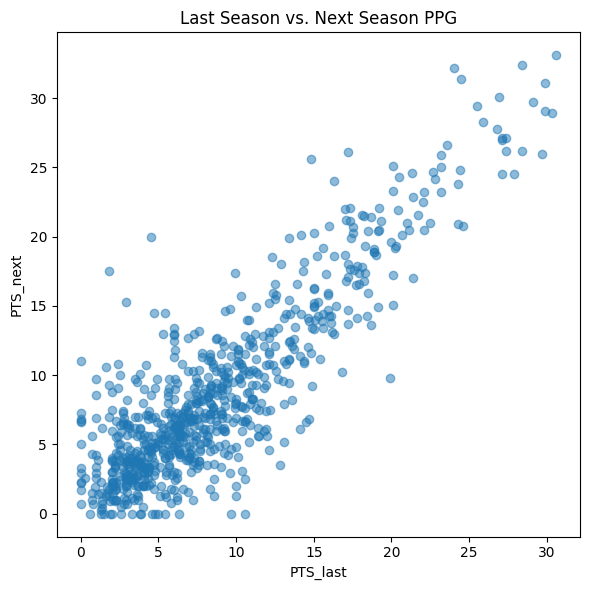

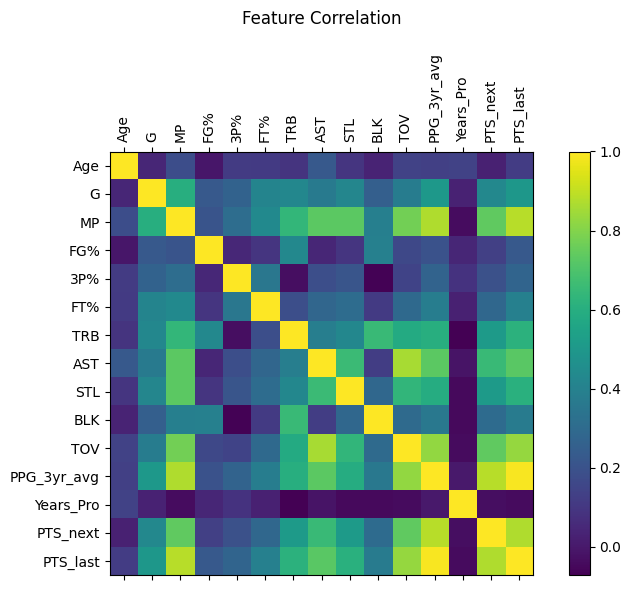

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(df_proc['PTS_last'], df_proc['PTS_next'], alpha=0.5)
plt.title('Last Season vs. Next Season PPG')
plt.xlabel('PTS_last')
plt.ylabel('PTS_next')
plt.tight_layout()
plt.show()
corr = df_proc.select_dtypes(include=[np.number]).corr()
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(corr)
fig.colorbar(cax) 
ax.set_xticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticks(range(len(corr.index)))
ax.set_yticklabels(corr.index)
ax.set_title('Feature Correlation', pad=20)
plt.tight_layout()
plt.show()

In [9]:
test_season = sorted(df['Season'].unique())[-1]
print(f"Holding out season- {test_season}")
train_mask = df['Season'] != test_season
test_mask  = df['Season'] == test_season
X_train = df_proc[train_mask].drop(columns=['PTS_next'])
y_train = df_proc.loc[train_mask,  'PTS_next']
X_test  = df_proc[test_mask].drop(columns=['PTS_next'])
y_test  = df_proc.loc[test_mask,   'PTS_next']
baseline = X_test['PTS_last']
print("Baseline MAE-", mean_absolute_error(y_test, baseline))
print("Baseline RMSE-", np.sqrt(mean_squared_error(y_test, baseline)))

Holding out season- 2022-2023
Baseline MAE- 1.9071428571428573
Baseline RMSE- 2.871908275495083


In [10]:
numeric_feats     = ['Age','G','MP','FG%','3P%','FT%','TRB','AST','STL','BLK','TOV','PTS_last']
categorical_feats = ['Pos']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', OneHotEncoder(drop='first'), categorical_feats)
])

In [11]:
models = {
    'Ridge': {
        'pipe': Pipeline([('pre', preprocessor), ('reg', Ridge())]),
        'params': {'reg__alpha': [0.1, 1.0, 10.0, 100.0]}
    },
    'Lasso': {
        'pipe': Pipeline([('pre', preprocessor), ('reg', Lasso(max_iter=5000))]),
        'params': {'reg__alpha': [0.001, 0.01, 0.1, 1.0]}
    },
    'RandomForest': {
        'pipe': Pipeline([('pre', preprocessor),
                          ('reg', RandomForestRegressor(random_state=42))]),
        'params': {
            'reg__n_estimators': [100, 200],
            'reg__max_depth': [None, 5, 10]
        }
    }
}

In [12]:
tscv = TimeSeriesSplit(n_splits=3)
results = {}
for name, spec in models.items():
    print(f"\nTuning {name}...")
    grid = GridSearchCV(
        spec['pipe'],
        spec['params'],
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    y_pred = best.predict(X_test)
    results[name] = {
        'best_params': grid.best_params_,
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }
    print(f"{name}: MAE={results[name]['MAE']:.2f}, RMSE={results[name]['RMSE']:.2f}, best={results[name]['best_params']}")


Tuning Ridge...
Ridge: MAE=2.04, RMSE=2.82, best={'reg__alpha': 1.0}

Tuning Lasso...
Lasso: MAE=1.95, RMSE=2.79, best={'reg__alpha': 0.1}

Tuning RandomForest...
RandomForest: MAE=1.98, RMSE=2.71, best={'reg__max_depth': 5, 'reg__n_estimators': 200}


In [13]:
summary = pd.DataFrame(results).T
print("\n=== Model comparison ====")
print(summary[['MAE','RMSE','best_params']])


=== Model comparison ====
                   MAE      RMSE  \
Ridge         2.037138  2.820472   
Lasso          1.95141  2.788088   
RandomForest  1.979335   2.71083   

                                                  best_params  
Ridge                                     {'reg__alpha': 1.0}  
Lasso                                     {'reg__alpha': 0.1}  
RandomForest  {'reg__max_depth': 5, 'reg__n_estimators': 200}  
